早期的卷积神经网络: LeNet
LeNet是早期成功的神经网络
先使用卷积层来学习图片空间信息
然后使用全连接层来转换到类别空间

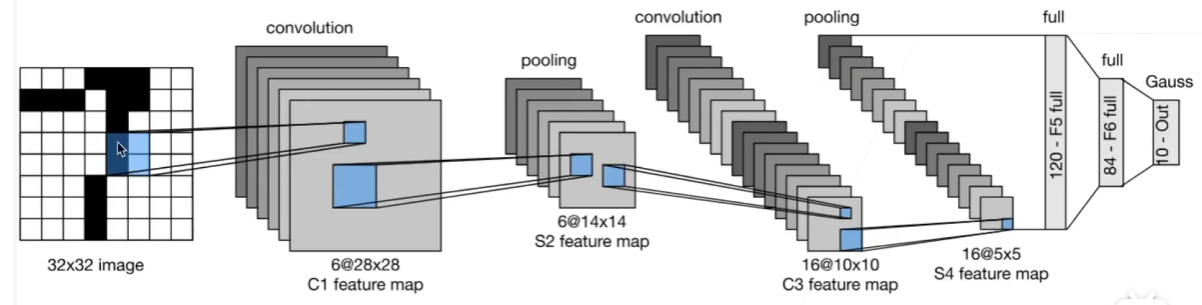

输入一个32×32的image
第一模块：包含5×5的6通道卷积和2×2的池化。
第二模块：和第一模块尺寸相同，通道数由6增加为16。
第三模块：包含5×5的120通道卷积。卷积之后的图像尺寸减小到1，但是通道数增加为120。
第一个全连接层的输出神经元的个数是64，第二个全连接层的输出神经元个数是分类标签的类别数，对于手写数字识别其大小是10。然后使用Softmax激活函数即可计算出每个类别的预测概率。

In [ ]:
# 代码实现
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    # MNIST图像原始是28x28像素的展平向量（784维），这里将展平图像恢复为单通道的2D图像格式，符合CNN输入要求
    def forward(self, x):
        return x.view(-1, 1, 28, 28)
# ​第使用之前学的Sequential自定义层:
net = torch.nn.Sequential(Reshape(),
                          # ​第1卷积层, 输入：1通道（灰度图）, 输出：6个特征图, 卷积核：5x5，填充2（保持输出尺寸为28x28）,​Sigmoid激活
                          nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
                          # ​平均池化, 2×2窗口, 输出尺寸：14x14（下采样减少计算量）
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          # ​第2卷积层, 输入：6通道, 输出：16个特征图, 卷积核：5x5（输出尺寸：10x10）,​Sigmoid激活
                          nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                          # ​再次平均池化, 输出尺寸：5x5（16个特征图）
                          nn.AvgPool2d(kernel_size=2, stride=2),
                          # ​展平层, nn.Flatten()将16x5x5的特征图展平为400维向量
                          nn.Flatten(),
                          # ​全连接层, 有两个隐藏层的多层感知机
                          # Linear(400 → 120) → Sigmoid → Linear(120 → 84) → Sigmoid → Linear(84 → 10)（输出10个类别概率）
                          nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
                          nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [7]:
# 看看我们构造的模型:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [8]:
# 导入fashion_mnist: 准备用于训练和测试的批量数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 切换模型为评估模式
        if not device:
            device = next(iter(net.parameters())).device # 获取模型所在设备
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        # 把x, y移动到设备上(kist特殊处理):
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1] # 总正确数 / 总样本数

上面for的那一段相当于这段:
for X, y in data_iter:
    X, y = X.to(device), y.to(device)  # 将数据移动到模型所在的设备（GPU加速）
    y_hat = net(X)                     # 前向传播获取预测结果
    acc = d2l.accuracy(y_hat, y)       # 计算本批次的正确预测数
    metric.add(acc, y.numel())         # 累积正确数和总样本数

In [ ]:
# 完整的神经网络训练流程实现，专为GPU优化设计，主要用于图像分类任务
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)   # Xavier初始化防止梯度爆炸/消失


    net.apply(init_weights) #对全连接层和卷积层初始化权重
    print('training on', device) # 检验当前是否在GPU上
    net.to(device) # 将模型转移到GPU
    optimizer = torch.optim.SGD(net.parameters(), lr=lr) # 随机梯度下降优化器
    loss = nn.CrossEntropyLoss()  # 分类任务常用损失函数
    # 画图
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # 训练循环框架
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # 累积 [损失总和, 正确数, 样本数]
        net.train() # 切换训练模式（启用Dropout等）

        for i, (X, y) in enumerate(train_iter):
            # 核心训练步骤
            timer.start()
            optimizer.zero_grad()  # 清空梯度
            X, y = X.to(device), y.to(device) # 数据移至GPU
            y_hat = net(X)  # 前向传播
            l = loss(y_hat, y) # 计算损失
            l.backward() # 反向传播
            optimizer.step() # 参数更新

            with torch.no_grad(): # 禁用梯度计算
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2] # 全局平均损失（总损失 / 总样本数）
            train_acc = metric[1] / metric[2] # 全局准确率（总正确数 / 总样本数）
            # # 每个epoch内每20%进度更新一次训练曲线
            # 训练损失（蓝色）
            # 训练准确率（橙色）
            # 测试准确率（绿色）
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
                # # 每个epoch结束后更新测试准确率

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}') # 最终输出指标
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}') # 计算吞吐量

epoch（训练轮次）​ 是指 ​完整遍历整个训练数据集一次 的过程。简要来说：

​定义：模型看过训练集中所有样本一次
​作用：
让模型逐步学习数据特征, 通常需要多个epoch（如10~100轮）才能达到较好效果
​示例：
训练集有50,000张图片，batch_size=256
1个epoch ≈ 迭代196次（50,000/256≈196个batch）

loss 0.467, train acc 0.824, test acc 0.820
48627.1 examples/sec on cuda:0


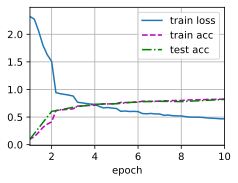

In [11]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

AlexNet: 更深更大的LeNet
主要改进: 
丢弃法
ReLU
平均池化变为MaxPooling
计算机视觉方法论的改变

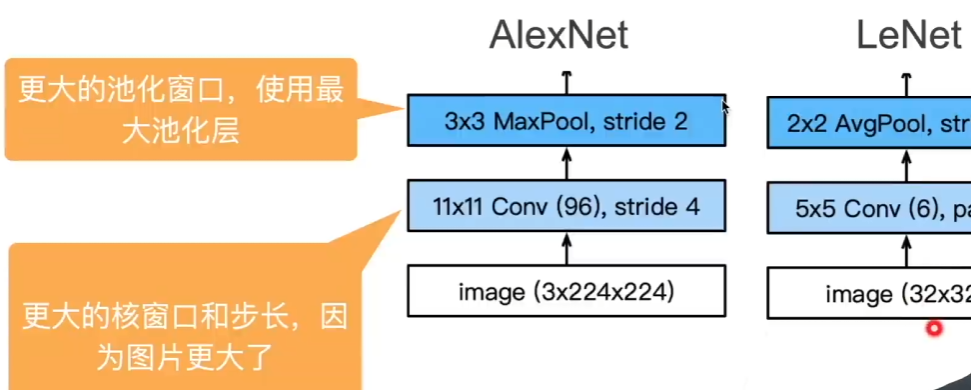

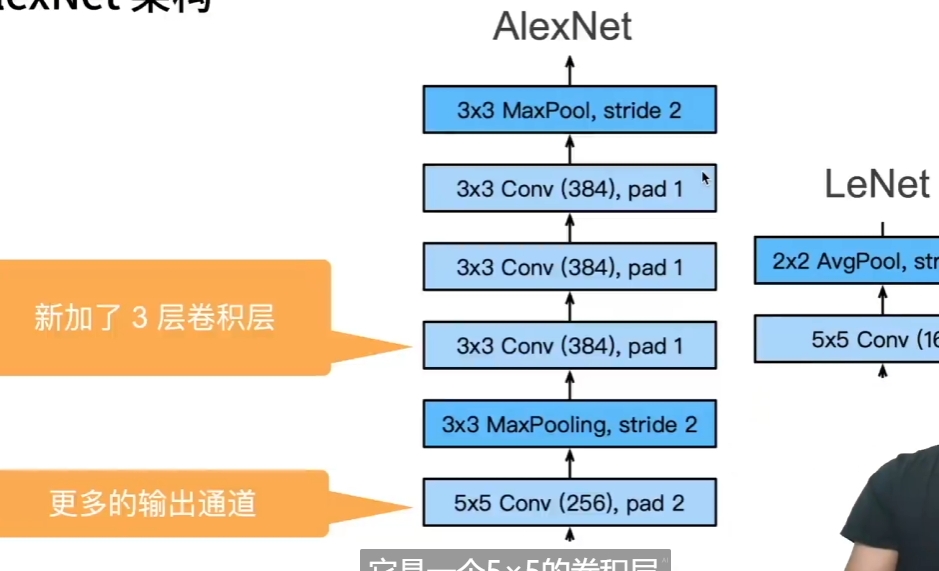

AlexNet相对于LeNet相比, 为了识别更大的模式, 用了更多的输出通道
卷积-池化-卷积-卷积-卷积-池化

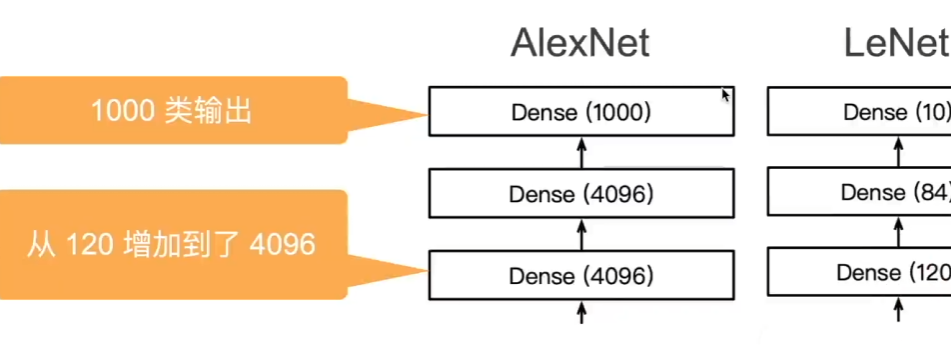

In [ ]:
# 代码实现, 大差不差, 只是层的构建不同
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 10))

In [ ]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'Output shape:\t', X.shape)

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())